<a href="https://colab.research.google.com/github/VasundharaSK/NewsClassification/blob/main/NewsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text classification is a supervised learning technique so we’ll need some labeled data to train our model. I’ll be using this public news classification dataset. It’s a manually labeled dataset of news articles which fit into one of 4 classes: Business, SciTech, Sports or World.

In [2]:
import pandas as pd
import numpy as np
import json

In [3]:
from google.colab import files
uploaded = files.upload()

Saving nlp_utils_news.ipynb to nlp_utils_news (1).ipynb


In [ ]:
#Loading additional helper functions not shown here but provided in the folder
%run nlp_utils_news.ipynb

'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

In [ ]:
'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''Display'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [9]:
from google.colab import files
uploaded = files.upload()

Saving News Classification DataSet.json to News Classification DataSet.json


In [10]:
#Load the JSON Data into a df

data = []

for line in open(r'News Classification DataSet.json', 'r'):
    data.append(json.loads(line))

content, label = [], []
for each in data:
    content.append(each['content'])
    label.append(each['annotation']['label'][0])

df = pd.DataFrame([content, label]).T
df.columns= ['content', 'label']
df.head()

,content,label
0,Unions representing workers at Turner Newall...,Business
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech
2,AP - A company founded by a chemistry research...,SciTech
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech
4,AP - Southern California's smog-fighting agenc...,SciTech


In [11]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [12]:
#Apply the function to preprocess the text. Tokenize, lower, expand contactions, lemmatize, remove punctuation, numbers and stop words
#process_text is defined in other code which is imported 
df['clean_text'] = df['content'].apply(process_text)
df.head()

,content,label,clean_text
0,Unions representing workers at Turner Newall...,Business,"[union, represent, worker, turner, newall, dis..."
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech,"[space.com, toronto, canada, second, team, roc..."
2,AP - A company founded by a chemistry research...,SciTech,"[company, chemistry, researcher, university, l..."
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech,"[it is, barely, dawn, mike, fitzpatrick, start..."
4,AP - Southern California's smog-fighting agenc...,SciTech,"[southern, california's, smog-fighting, agency..."


In [13]:
#Top 20 most frequent words for all the articles
#word_freq is defined in nlp_utils_news.ipynb
cl_text_list = df['clean_text'].tolist()
wf = word_freq(cl_text_list, 20)
wf.head(20)

,0,1
0,new,1077
1,reuters,793
2,year,699
3,company,590
4,quot,551
5,monday,498
6,tuesday,497
7,thursday,458
8,wednesday,447
9,win,418


In [14]:
#Avg word count by category
#word_count is defined in nlp_utils_news.ipynb
df['word_count'] = df['content'].apply(word_count)
avg_wc = df.groupby('label').mean().reset_index()
avg_wc[['label','word_count']]

,label,word_count
0,Business,31.36
1,SciTech,30.77
2,Sports,31.35
3,World,31.74


In [15]:
#Preparing the dataframes

#Splitting the df into the different categories
df_business = df.loc[df['label'] == 'Business'] 
df_sports = df.loc[df['label'] =='Sports']
df_scitech = df.loc[df['label'] == 'SciTech'] 
df_world = df.loc[df['label'] =='World']

In [16]:
df_scitech.shape

(1900, 4)

In [17]:
df_world.shape

(1900, 4)

In [18]:
df_sports.shape

(1900, 4)

In [19]:
df_business.shape

(1900, 4)

In [20]:
#Randomly sampling business and sports to create imbalanced classes
df_business = df_business.sample(n=1005, random_state=3)
df_sports = df_sports.sample(n=805, random_state=3)

In [21]:
#Holding out 5 articles from each class for prediction at the end
df_business_holdout = df_business.iloc[:5]
df_sports_holdout = df_sports.iloc[:5]
df_scitech_holdout = df_scitech.iloc[:5]
df_world_holdout = df_world.iloc[:5]

df_business = df_business.iloc[5:]
df_sports = df_sports.iloc[5:]
df_scitech = df_scitech.iloc[5:]
df_world = df_world.iloc[5:]

In [22]:
#Appending the dfs back together
df = pd.concat([df_business, df_sports, df_scitech, df_world])
df_holdout = pd.concat([df_business_holdout, df_sports_holdout, df_scitech_holdout, df_world_holdout])

In [23]:
#Turning the labels into numbers
LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['label'])

In [24]:
display(df.groupby(['label'])['content'].count())
display(df_holdout.groupby(['label'])['content'].count())
display(df['label'].unique())
display(df['label_num'].unique())

label
Business    1000
SciTech     1895
Sports       800
World       1895
Name: content, dtype: int64

label
Business    5
SciTech     5
Sports      5
World       5
Name: content, dtype: int64

array(['Business', 'Sports', 'SciTech', 'World'], dtype=object)

array([0, 2, 1, 3])

In [25]:
#Top 15 words by category. Taking bigrams into account


top_n = 15
text_bus = df_business['clean_text'].tolist()
text_sci_t = df_scitech['clean_text'].tolist()
text_sports = df_sports['clean_text'].tolist()
text_world = df_world['clean_text'].tolist()

#word_freq_bigrams imported from nl_utils_news.ipynb

bus = word_freq_bigrams(text_bus, top_n=top_n)
sci_t = word_freq_bigrams(text_sci_t, top_n=top_n)
sports = word_freq_bigrams(text_sports, top_n=top_n)
world = word_freq_bigrams(text_world, top_n=top_n)

df_wf = pd.concat([bus, sci_t, sports, world], axis=1)
cols = ['business', 'count', 'sci tech', 'count', 'sports', 'count', 'world', 'count']
df_wf.columns = cols
df_wf

,business,count,sci tech,count,sports,count,world,count
0,company,125,new,186,win,99,monday,129
1,new_york,111,company,180,game,97,reuters,119
2,year,90,quot,132,team,78,tuesday,118
3,reuters,81,software,123,season,68,friday,116
4,tuesday,75,microsoft,106,victory,57,iraq,115
5,wednesday,72,technology,106,play,56,quot,105
6,thursday,65,make,103,sunday,54,wednesday,105
7,new,64,use,102,year,54,official,104
8,share,63,year,100,run,44,country,103
9,report,59,reuters,100,new_york,44,leader,102


In [26]:
#Top 15 bigrams by category

bus_bigrams = bigram_freq(text_bus, top_n = top_n)
sci_t_bigrams = bigram_freq(text_sci_t, top_n = top_n)
sports_bigrams = bigram_freq(text_sports, top_n = top_n)
world_bigrams = bigram_freq(text_world, top_n = top_n)

df_bigram_wf = pd.concat([bus_bigrams, sci_t_bigrams, sports_bigrams, world_bigrams], axis=1)
df_bigram_wf.columns = cols
df_bigram_wf

,business,count,sci tech,count,sports,count,world,count
0,new_york,111,microsoft_corp,47,new_york,44,prime_minister,88
1,oil_price,39,mobile_phone,41,sport_network,29,president_bush,58
2,wall_street,32,san_francisco,29,world_cup,19,united_nation,55
3,chief_executive,30,new_york,28,champion_league,18,united_state,48
4,quote_profile,27,video_game,28,red_sox,17,yasser_arafat,37
5,united_state,22,search_engine,27,st_louis,16,presidential_election,36
6,london_reuters,18,apple_computer,23,boston_red,15,kill_people,35
7,san_francisco,17,year_ago,19,united_state,13,new_york,34
8,crude_oil,16,sun_microsystems,19,houston_astros,12,north_korea,33
9,chicago_reuters,15,united_state,19,los_angeles,12,canadian_press,28


<function matplotlib.pyplot.show>

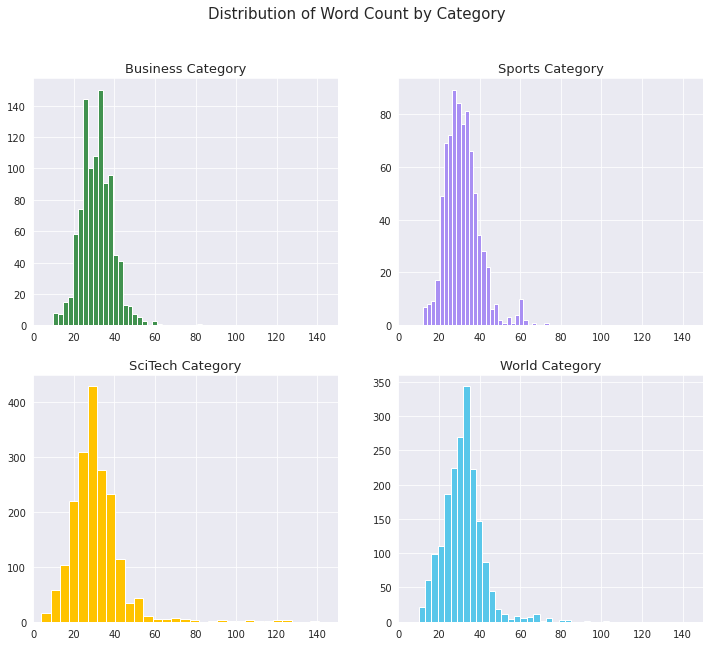

In [27]:
#Plot the distribution of word count by article

fig, ax = plt.subplots(2, 2, figsize = (12,10))
fig.suptitle('Distribution of Word Count by Category', fontsize=15)

bins = 30

ax[0, 0].hist(df_business['word_count'], bins = bins, color = '#41924F')
ax[0, 0].set_title('Business Category', fontsize = 13)
ax[0, 0].set_xlim(0, 150)

ax[1, 0].hist(df_scitech['word_count'], bins = bins, color = '#FFC300')
ax[1, 0].set_title('SciTech Category', fontsize = 13)
ax[1, 0].set_xlim(0, 150)

ax[0, 1].hist(df_sports['word_count'], bins = bins, color = '#a98ff3')
ax[0, 1].set_title('Sports Category', fontsize = 13)
ax[0, 1].set_xlim(0, 150)

ax[1, 1].hist(df_world['word_count'], bins = bins, color = '#59C7EA')
ax[1, 1].set_title('World Category', fontsize = 13)
ax[1, 1].set_xlim(0, 150)

plt.show

The ‘term frequency’ is just the number of times a word appears in a document, divided by the total number of words in that document. The ‘inverse document frequency’ is the logarithm of the number of total documents divided by the number of documents the word appears in. Pretty straight forward.

In [28]:
#Creating the features (tf-idf weights) for the processed text

texts = df['clean_text'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['label_num'].values #target

print (X.shape)
print(y.shape)

(5590, 15137)
(5590,)


Sklearn’s tf-idf vectorizer has a few other helpful features we will use, especially ‘ngram_range’ and ‘max/min_df’. We’ll use an ngram_range of 1, 2 which takes unigrams and bigrams into account. The max_df tells the algorithm to ignore words that appear in more than the threshold set. We’ll set it to .95 which will ignore words that appear in 95% or more of all documents.

The min_df ignores words that appear in less that the threshold. We’ll set it to 2 which will ignore words that only appear in 2 or less documents. This will help get rid of frequent terms (max_df) and infrequent terms (min_df).

In [29]:
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(5590, 100)

LSA is known to combat the effects of synonymy and polysemy (both of which roughly mean there are multiple meanings per word), which cause term-document matrices to be overly sparse and exhibit poor similarity under measures such as cosine similarity”

**Accuracy** - simply the fraction of samples predicted correctly
**Precision** - the ratio of true positives to false positives or the ability of the classifier not to label a positive sample as negative
**Recall** - the ratio of true positives to false negatives or the ability of the classifier to find all the positive samples
**F1 Score** - The harmonic average of precision and recall
Precision-Recall Curve (graph): It shows the trade off between precision and recall. A high area under the curve (AUC) represents both high recall and high precision. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall)

 A **macro-average** will compute the metric independently for each class and then take the average (hence treating all classes equally)

whereas a **micro-average** will aggregate the contributions of all classes to compute the average metric.



Micro-average Method
In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets and the apply them to get the statistics. For example, for a set of data, the system's

True positive (TP1)  = 12
False positive (FP1) = 9
False negative (FN1) = 3
Then precision (P1) and recall (R1) will be 57.14%=TP1TP1+FP1 and 80%=TP1TP1+FN1

and for a different set of data, the system's

True positive (TP2)  = 50
False positive (FP2) = 23
False negative (FN2) = 9
Then precision (P2) and recall (R2) will be 68.49 and 84.75

Now, the average precision and recall of the system using the Micro-average method is

Micro-average of precision=(TP1+TP2)/
                  (TP1+TP2+FP1+FP2)=(12+50)/(12+50+9+23)   = 65.96

Micro-average of recall=(TP1+TP2)/(TP1+TP2+FN1+FN2)=(12+50)/(12+50+3+9)= 83.78

The Micro-average F-Score will be simply the harmonic mean of these two figures.

2. Macro-average Method
The method is straight forward. Just take the average of the precision and recall of the system on different sets. For example, the macro-average precision and recall of the system for the given example is

Macro-average precision=P1+P22=57.14+68.492= 62.82 
Macro-average recall=R1+R22=80+84.752= 82.25

The Macro-average F-Score will be simply the harmonic mean of these two figures.

Suitability Macro-average method can be used when you want to know how the system performs overall across the sets of data. You should not come up with any specific decision with this average.

On the other hand, micro-average can be a useful measure when your dataset varies in size.

In [30]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

,model_name,accuracy_score,precision_score,recall_score,f1_score
2,Random Forest,0.82,0.82,0.80,0.81
1,Stochastic Gradient Descent,0.80,0.81,0.77,0.79
4,AdaBoost,0.75,0.74,0.74,0.74
6,K Nearest Neighbor,0.71,0.71,0.69,0.70
5,Gaussian Naive Bayes,0.69,0.69,0.71,0.68
3,Decsision Tree,0.69,0.67,0.67,0.67
0,Dummy,0.29,0.26,0.26,0.26


For multiclass classification you also need to select the type of averaging for these metrics as they are calculated per class. The discussion of what’s best and what you should use depends on your situation and is beyond the scope of this article but in general I find macro averaging the most useful (which is what I’m using here). It computes F1 scores for each class and returns the average of those scores. 

In [ ]:
#Hyperparameter tuning
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!

#SGD
loss =  ['log']
penalty = ['l2','l1']
alpha = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [5, 1000, 2000 ]
tol = [None, 1e-3]
eta0 = [0.1, 0.001]

random_state = [3]

clf = SGDClassifier()

params = dict(loss=loss,
              penalty=penalty,
              alpha=alpha,
              max_iter=max_iter,
              tol=tol,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params,
                          cv = 5,
                          verbose = 1, 
                          n_jobs = -1)

sgd_best_model = gridsearch.fit(X, y)

In [ ]:
best_model_sgd = gridsearch.best_params_
print(best_model_sgd)

In [ ]:
#Hyperparameter tuning
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!

#RF
bootstrap = [True, False]
max_depth = [10, 50, 100, None]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
n_estimators = [800, 1400, 1000]
random_state = [3]

clf = RandomForestClassifier()

params = dict(bootstrap = bootstrap,
              max_depth = max_depth,
              max_features = max_features,
              min_samples_leaf = min_samples_leaf,
              n_estimators = n_estimators,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

rf_best_model = gridsearch.fit(X, y)

In [ ]:
best_model_rf = gridsearch.best_params_
print(best_model_rf)

In [31]:
#Define the best models with the selected params from the grdsearch
#Gridsearch was done on a virtual machine outisde of this notebook
#Normally you can just say 'best_model = gridsearch.best_params_' 
#to use the best parameters from the gridsearch

sgd_best_model = SGDClassifier(alpha=1e-06,
                               loss='log',
                               max_iter=1000,
                               penalty='l2',
                               learning_rate = 'constant',
                               eta0 = .1,
                               random_state = 3,
                               tol=None)

rf_best_model = RandomForestClassifier(bootstrap = False,
                                       max_depth = 50,
                                       max_features = 'auto',
                                       min_samples_leaf = 1,
                                       n_estimators = 1400,
                                       random_state=3)

In [32]:
#Plot AUC - SGD

#Binarize the labels
y_b = label_binarize(y, classes = [0, 1, 2, 3])
n_classes = y_b.shape[1]

#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 3)

#Learn to predict each class against the other
sgd_classifier = OneVsRestClassifier(sgd_best_model)

y_score = sgd_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

In [33]:
#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])


First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])


#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - SGD (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

SyntaxError: ignored

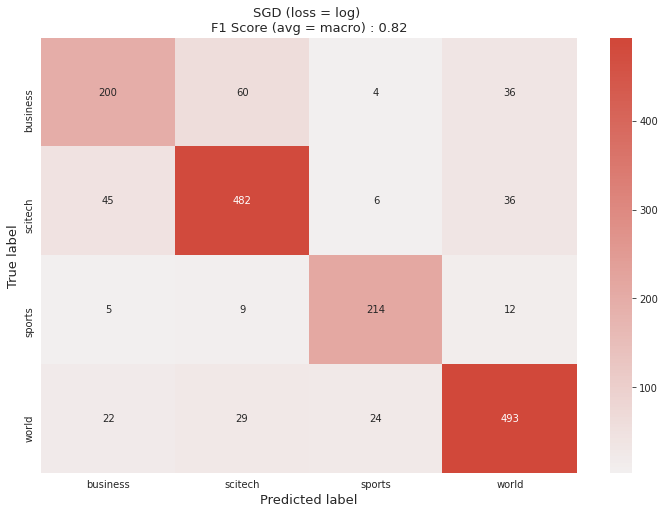

In [34]:
#Confusion Matrix - SGD

#Train test split with stratified sampling. Using non-binarized labels
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
#Fit the training data
sgd_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = sgd_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['business','scitech','sports', 'world'], 
                     columns = ['business','scitech','sports', 'world'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('SGD (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

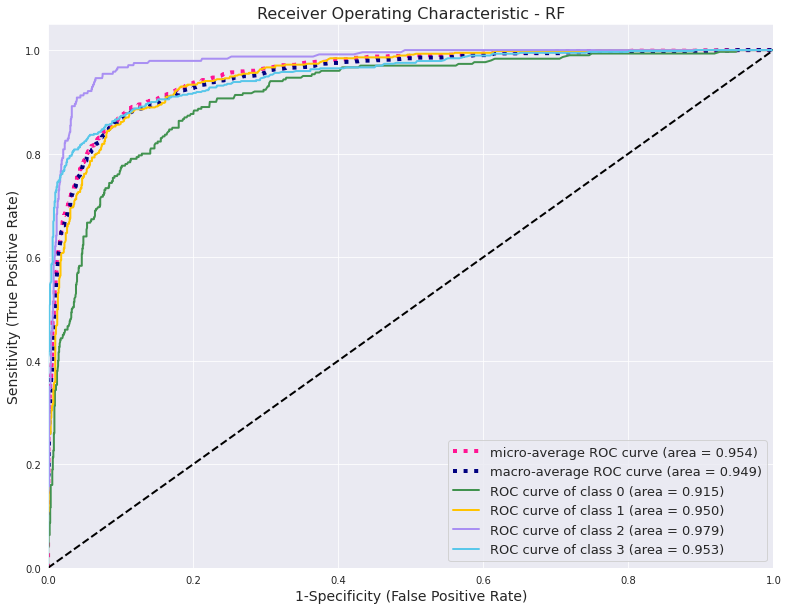

In [35]:
#Plot AUC - RF

#Learn to predict each class against the other
rf_classifier = OneVsRestClassifier(rf_best_model)

y_score = rf_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - RF', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

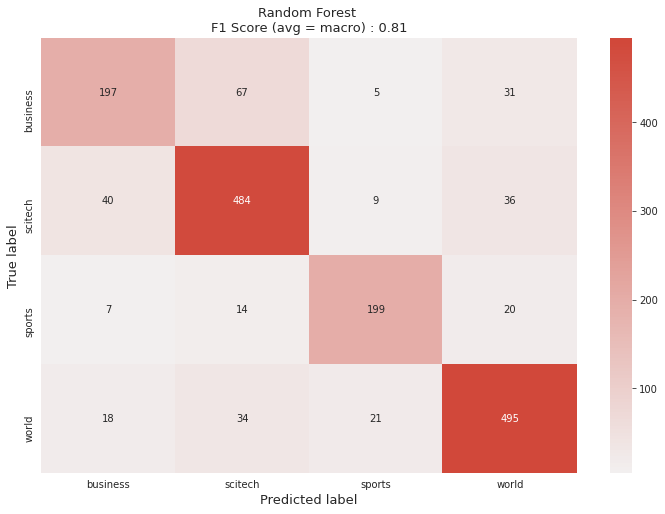

In [36]:
#Confusion Matrix - RF

#Fit the training data
rf_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = rf_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['business','scitech','sports', 'world'], 
                     columns = ['business','scitech','sports', 'world'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Random Forest \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

In [37]:
#Putting it all together to make predictions on the unseen text

#Get the text of the 5 articles we held out from each of the categories in the beginning
unseen = df_holdout['clean_text'].astype('str') 

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)

#Fit the models with the best params on the full data
sgd_best_model.fit(X, y)
rf_best_model.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_sgd'] = sgd_best_model.predict(X_unseen)
df_holdout['pred_rf'] = rf_best_model.predict(X_unseen)

label_num_dict = {'Business': 0,
                  'SciTech': 1,
                  'Sports': 2,
                  'World': 3}

df_holdout['correct'] = df_holdout['label'].map(label_num_dict)
df_holdout = df_holdout.drop('clean_text', 1)
df_holdout = df_holdout[['content', 'label', 'pred_sgd', 'pred_rf', 'correct']]

df_holdout

,content,label,pred_sgd,pred_rf,correct
5051,If you #39;ve ever been in an airplane that ha...,Business,1,1,0
6272,NEW YORK (Reuters) - U.S. stocks rose on Monda...,Business,0,0,0
3341,US stocks looked to open flat on Thursday unde...,Business,0,0,0
6067,AP - The United States and Australia have prev...,Business,3,3,0
4673,NEW YORK (Reuters) - U.S. stocks jumped on Wed...,Business,0,0,0
4848,VIENNA (Reuters) - Top seed Amelie Mauresmo re...,Sports,2,2,2
6232,Feyenoord boss Ruud Gullit has launched a stin...,Sports,2,1,2
3072,Jim Mora thought his team deserved a little so...,Sports,2,2,2
6007,Motorsport.com. Reports this week suggest that...,Sports,1,1,2
4431,Race fans wave American flags in the stands du...,Sports,2,2,2


In [2]:
#Using the original full unsampled dataset for predictions

data = []

for line in open(r'News Classification DataSet.json', 'r'):
    data.append(json.loads(line))

content, label = [], []
for each in data:
    content.append(each['content'])
    label.append(each['annotation']['label'][0])
    
df = pd.DataFrame([content, label]).T
df.columns= ['content', 'label']

#Splitting the df into business and sports articles
df_business = df.loc[df['label'] == 'Business'] 
df_sports = df.loc[df['label'] =='Sports']
df_scitech = df.loc[df['label'] == 'SciTech'] 
df_world = df.loc[df['label'] =='World']

#Holding out 5 articles from each class for prediction at the end
df_business_holdout = df_business.iloc[:5]
df_sports_holdout = df_sports.iloc[:5]
df_scitech_holdout = df_scitech.iloc[:5]
df_world_holdout = df_world.iloc[:5]

df_business = df_business.iloc[5:]
df_sports = df_sports.iloc[5:]
df_scitech = df_scitech.iloc[5:]
df_world = df_world.iloc[5:]

#Appending the dfs back together
df = pd.concat([df_business, df_sports, df_scitech, df_world])
df_holdout = pd.concat([df_business_holdout, df_sports_holdout, df_scitech_holdout, df_world_holdout])

df['clean_text'] = df['content'].apply(process_text) 

#Turning the labels into numbers
LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['label'])

#Get the text of the 5 articles we held out from each of the categories in the beginning
df_holdout['clean_text'] = df_holdout['content'].apply(process_text) 
unseen = df_holdout['clean_text'].astype('str') 

#Creating the features (tf-idf weights) for the processed text
texts = df['clean_text'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['label_num'].values #target

#Dimenionality reduction. Only using the 100 best features
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)

#Fit the models with the best params on the full data
sgd_best_model.fit(X, y)
rf_best_model.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_sgd'] = sgd_best_model.predict(X_unseen)
df_holdout['pred_rf'] = rf_best_model.predict(X_unseen)

label_num_dict = {'Business': 0,
                  'SciTech': 1,
                  'Sports': 2,
                  'World': 3}

df_holdout['correct'] = df_holdout['label'].map(label_num_dict)
df_holdout = df_holdout.drop('clean_text', 1)
df_holdout = df_holdout[['content', 'label', 'pred_sgd', 'pred_rf', 'correct']]

df_holdout

FileNotFoundError: ignored